# Testing

Testing out DNE method, possibly along with others, to get a working version

_Had issues with PyTorch 2.5.0, so downgraded to 2.4.0_

In [1]:
import os
import torch
import time
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance
from torch.utils.data import DataLoader
import testing_utils as tu
from testing_utils.dne import *
from testing_utils.datasets import *

529 1058
['cable', 'leather', 'toothbrush']
torch.Size([3, 224, 224])
[0, 0, 1, 1]


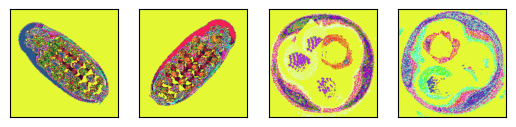

In [16]:
# Example dataset
mvtec_mcil_train = mvtec(task=2, cutpaste=True)
print(int(len(mvtec_mcil_train) / 2), len(mvtec_mcil_train))
print(mvtec_mcil_train.categories)
data = []
labels = []
for i in range(527, 531):
    img = mvtec_mcil_train[i][0]
    data.append(img)
    labels.append(mvtec_mcil_train[i][1])
tu.show(data)
print(mvtec_mcil_train[0][0].shape)
print(labels)

In [20]:
# Params, based on paper, and if not there, in code (configs)
num_epochs = 50
batch_size = 32
weight_decay = 0.00003
lr = 0.0001
alpha = 0.4

model = DNE()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model.train()
total_train_time = 0
for t in range(1, 6):  # task, t
    """
    Training
    - 1 epoch takes ~ 47 seconds to train, so 47 sec * 50 epochs ~ 39.2 minutes per task
    - If there are 5 tasks, then training time for all tasks for one experiment would be ~ 3 hours 16 minutes
    """
    print(f'---Task {t}/5---')
    # Train classifier head only on first task
    if t == 1:
        model.freeze_head(False)
        print('Head Classifier: NOT Frozen')
    else:
        model.freeze_head(True)
        print('Head Classifier: Frozen')

    # Create dataset
    train_data = mvtec(multi=True, mtd=False, train=True, task=t, cutpaste=True)
    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True)
    print('Train Data Length:', len(train_data))
    print()
    num_batches = len(train_dataloader)
    task_train_time = 0

    for e in range(num_epochs):
        # Each epoch seems to run quickly, so we will calculate time and loss per epoch
        start = time.time()
        epoch_loss = 0

        # Only update z-epoch at final epoch
        update_z_epoch = True if ((e + 1) == num_epochs) else False

        # Iterate through each batch
        for batch_idx, (imgs, labels, category) in enumerate(train_dataloader):
            # print(imgs.shape)
            # print(labels.shape)
            # print(category)
            optimizer.zero_grad()
            imgs = imgs.to(model.device)
            outputs = model(imgs, head=True,
                            add_to_z_epoch=update_z_epoch).cpu()
            loss = criterion(outputs, labels)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        end = time.time()
        epoch_time = end - start
        task_train_time += epoch_time
        if (e + 1) % 10 == 0:
            print('Epoch {}/{}'.format(e + 1, num_epochs))
            if update_z_epoch:
                print('Updated Z Epoch')
            print('Epoch time: {:.1f} seconds'.format(epoch_time))
            print('Epoch loss: {:.5f}'.format(epoch_loss))
            print()

    # Updates the memory, M, with statistics from current task after epoch 50
    model.update_memory()

    task_train_time /= 60  # puts total task train time in minutes
    print(f'Task Training Time: {task_train_time:.2f} minutes')
    print()
    total_train_time += task_train_time

print(f'Total Experiment Training Time: {total_train_time / 60:.2f} hours')
z_global = model.generate_global_samples().cpu()

Using cuda device
---Task 1/5---
Head Classifier: NOT Frozen
Train Data Length: 1660

Epoch 10/50
Epoch time: 46.8 seconds
Epoch loss: 0.00183

Epoch 20/50
Epoch time: 47.3 seconds
Epoch loss: 0.00071

Epoch 30/50
Epoch time: 47.0 seconds
Epoch loss: 0.47032

Epoch 40/50
Epoch time: 47.5 seconds
Epoch loss: 0.00496

Epoch 50/50
Updated Z Epoch
Epoch time: 47.4 seconds
Epoch loss: 0.00350

Task Training Time: 39.26 minutes

---Task 2/5---
Head Classifier: Frozen
Train Data Length: 1058

Epoch 10/50
Epoch time: 34.0 seconds
Epoch loss: 0.59408

Epoch 20/50
Epoch time: 34.7 seconds
Epoch loss: 0.40245

Epoch 30/50
Epoch time: 34.7 seconds
Epoch loss: 0.06237

Epoch 40/50
Epoch time: 34.0 seconds
Epoch loss: 0.22704

Epoch 50/50
Updated Z Epoch
Epoch time: 34.1 seconds
Epoch loss: 0.24918

Task Training Time: 28.54 minutes

---Task 3/5---
Head Classifier: Frozen
Train Data Length: 1304

Epoch 10/50
Epoch time: 37.2 seconds
Epoch loss: 0.00155

Epoch 20/50
Epoch time: 36.9 seconds
Epoch los

In [21]:
"""
Testing
- Paper shows accuracies, but I'm not sure how that would work
- You can only computer anomaly scores using Mahalanobis distance after training all tasks,
    as it requires the global distribution across all tasks
- Even then, they don't show any threshold for Mahalanobis distance in paper
- For now, we will look at accuracy of model based on head output
- This point of testing is to mimic figure 3, where we show avg. accuracy of past tasks
"""
# TODO: Look for Mahalanobis distance threshold in code for anomaly data
# Now, we want to calculate our global distribution
# self.z_global should have a size N x 768
# where N = number of samples from all tasks
# CAD code has an alpha parameter = 0.4, and alpha in paper is the shrinkage
cov_shrunk = ShrunkCovariance(store_precision=True, shrinkage=0.4)
cov_shrunk.fit(z_global.numpy())

model.eval()
total_test_time = 0
distance_scores = None
all_labels = None
avg_test_accuracy = []
for t in range(1, 6):  # task, t
    print(f'---Task {t}/5---')

    # Create dataset
    test_data = mvtec(multi=True, mtd=False, train=False, task=t)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=True)
    num_batches = len(test_dataloader)
    task_test_time = 0

    start = time.time()
    task_num_correct = 0

    with torch.no_grad():
        # Iterate through each batch
        for batch_idx, (imgs, labels, category) in enumerate(test_dataloader):
            # print(imgs.shape)
            # print(labels.shape)
            # print(category)
            imgs = imgs.to(model.device)
            outputs = model(imgs, head=True,
                            add_to_z_epoch=False).cpu()
            task_num_correct += sum(torch.argmax(outputs, dim=1) == labels).item()
            embeds = model.embed(imgs).cpu()
            if distance_scores is None:
                distance_scores = cov_shrunk.mahalanobis(embeds)
                all_labels = labels.cpu().numpy()
            else:
                distance_scores = np.concatenate((distance_scores,
                                                  cov_shrunk.mahalanobis(embeds)))
                all_labels = np.concatenate((all_labels,
                                             labels.cpu().numpy()))

    end = time.time()
    task_test_time = end - start
    total_test_time += task_test_time
    task_test_accuracy = task_num_correct / len(test_data)
    avg_test_accuracy.append(task_test_accuracy)
    print('Task time: {:.1f} seconds'.format(task_test_time))
    print('Task Accuracy: {:.3f}'.format(task_test_accuracy))
    print()

total_test_time /= 60  # puts total task test time in minutes
print(f'Total Test Time: {total_test_time:.2f} minutes')
print(f'Average Test Accuracy: {np.mean(avg_test_accuracy):.3f}')
print()

---Task 1/5---
Task time: 9.4 seconds
Task Accuracy: 0.300

---Task 2/5---
Task time: 10.4 seconds
Task Accuracy: 0.323

---Task 3/5---
Task time: 11.5 seconds
Task Accuracy: 0.303

---Task 4/5---
Task time: 12.3 seconds
Task Accuracy: 0.201

---Task 5/5---
Task time: 9.6 seconds
Task Accuracy: 0.242

Total Test Time: 0.89 minutes
Average Test Accuracy: 0.274



0 467
1 1258


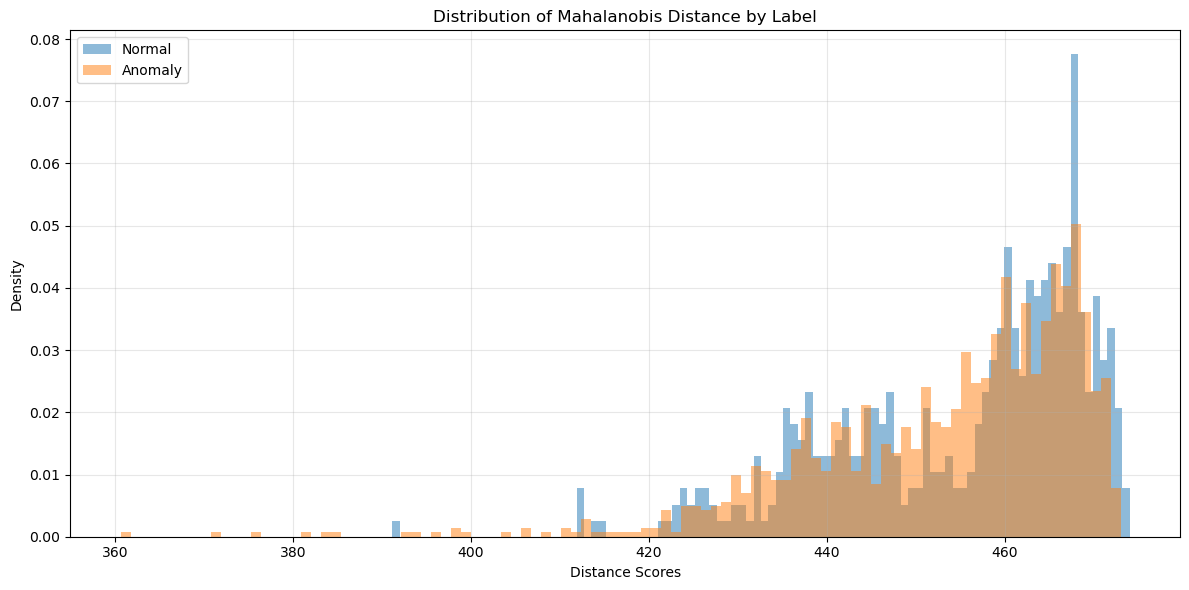

In [22]:
# plt.style.use('seaborn')
plt.figure(figsize=(12, 6))
for label in np.unique(all_labels):
    mask = (all_labels == label)
    print(label, len(distance_scores[mask]))
    plt.hist(distance_scores[mask], alpha=0.5, label='Anomaly' if label == 1 else 'Normal',
             bins=100, density=True)

plt.xlabel('Distance Scores')
plt.ylabel('Density')
plt.title('Distribution of Mahalanobis Distance by Label')
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()


In [66]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024 ** 2
print('model size: {:.2f} MB'.format(size_all_mb))

model size: 330.24 MB


In [2]:
('hello' / "traom" / 'good').glob('*.png')

TypeError: unsupported operand type(s) for /: 'str' and 'str'